### Introduction 
<br/>

LightGBM Version.

### Import Libraries

In [3]:
import os, sys, time, gc, warnings, re 
import datetime as dt
warnings.filterwarnings("ignore")

import itertools as it
import operator as op

import numpy as np
import scipy.stats as stats
import scipy as sp
import pandas as pd

import statsmodels.tsa as smt

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML, Markdown

sys.path.append(os.environ["PY_UTILITIES_LIBRARY"]) # PY_UTILITIES_LIBRARY points to our custom library

%matplotlib inline

In [4]:
%reload_ext watermark
%watermark -iv -d -t -v -w -m

statsmodels0.9.0
seaborn   0.9.0
scipy     1.2.1
pandas    0.24.2
re        2.2.1
numpy     1.16.2
matplotlib3.0.3
json      2.0.9
2019-05-08 23:45:34 

CPython 3.6.8
IPython 7.5.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores  : 12
interpreter: 64bit
watermark 1.8.0


### Configure Notebook

In [5]:
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_colwidth", -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('io.hdf.default_format','fixed') # store binary data in HDF5 'table' format or 'fixed' format
sns.set(context='paper', style="darkgrid", rc={'axes.labelcolor': 'black', 'xtick.color': 'black', 'ytick.color': 'black', 'figure.facecolor':'white'}, 
        font_scale=1.3)
HTML("<style>table {font-size:14px} </style>")

def printmd(string, color=None):
    """colors in hex"""
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [6]:
%reload_ext autoreload
%autoreload 2

rs_seed = np.random.RandomState(seed=43)

### Define Notebook Parameters

In [7]:
# see papermill package

In [8]:
# see papermill package
target = "avg_target"
object_id = "reservation_id"
lightgbm_dir = "./catboost_artifacts"

# imports
from ml_toolbelt.ioutils.file_utils import load_data
from ml_toolbelt.utils.mem_optimize_df import reduce_mem_usage

# ml imports
from lightgbm import LGBMRegressor
import lightgbm

from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

print("LightGBM: {}".format(lightgbm.__version__))

LightGBM: 2.2.3


In [9]:
train_df = reduce_mem_usage(pd.read_csv("./train_preproc_v1.csv"))
test_df = reduce_mem_usage(pd.read_csv("./test_preproc_v1.csv"))

print(train_df.shape, test_df.shape)
train_df.info()

Memory usage of dataframe is 102.13 MB
Memory usage after optimization is: 32.56 MB
Decreased by 68.1%
Memory usage of dataframe is 43.67 MB
Memory usage after optimization is: 14.14 MB
Decreased by 67.6%
(334675, 40) (146765, 39)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334675 entries, 0 to 334674
Data columns (total 40 columns):
reservation_id              334675 non-null object
channel_code                334675 non-null int8
main_product_code           334675 non-null int8
numberofadults              334675 non-null int8
numberofchildren            334675 non-null int8
persontravellingid          334675 non-null int16
resort_region_code          334675 non-null int8
resort_type_code            334675 non-null int8
room_type_booked_code       334675 non-null int8
roomnights                  334675 non-null int8
season_holidayed_code       334565 non-null float16
state_code_residence        330005 non-null float16
state_code_resort           334675 non-null int8
total_pax   

In [10]:
# fill NA's and typecast integer features
train_df[["season_holidayed_code", "state_code_residence"]] = train_df[["season_holidayed_code", "state_code_residence"]].apply(lambda x: x.fillna(-1).astype(np.int8))
test_df[["season_holidayed_code", "state_code_residence"]] = test_df[["season_holidayed_code", "state_code_residence"]].apply(lambda x: x.fillna(-1).astype(np.int8))
train_df[["season_holidayed_code", "state_code_residence"]][train_df["state_code_residence"] == -1].head()

,season_holidayed_code,state_code_residence
187,3,-1
188,4,-1
189,3,-1
190,3,-1
191,3,-1


In [11]:
# cat features
qualitative_features = ['cluster_code', 'channel_code', 'main_product_code', 'persontravellingid', 'resort_region_code', 'resort_type_code', 'room_type_booked_code', 
                        'member_age_buckets', 'booking_type_code', 'reservationstatusid_code', 'resort_id', 'season6_booking', 'season6_checkin',
                        'season_holidayed_code', 'state_code_residence', 'state_code_resort', 'checkin_month', 'checkin_dayofweek', 'checkin_weekofyear', 
                        'checkin_dayofyear', 'checkin_quarter']
remove_feats = ["memberid"]

In [27]:
# search space
search_space = {'objective': 'regression', 'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 
                'num_leaves': 43, 'n_estimators': 100, 'n_jobs': 4, 'min_child_samples': 20,
                'subsample': 0.8, 'bagging_freq': 1, 'colsample_bytree': 0.8, 
                'bagging_seed': 1, 'min_child_weight': 1, 'reg_alpha': 0.001, 'reg_lambda': 0.001,
                'min_split_gain': 0.0, 'subsample_for_bin': 25000, 'min_data_per_group': 100, 'max_cat_to_onehot': 4,
                'cat_l2': 10.0, 'cat_smooth': 10.0, "max_bin": 255, "min_data_in_bin": 3, 
                'max_cat_threshold': 32, 'metrics': ['rmse'], 'metric_freq': 1, "device_type": "cpu", "seed": 63, "silent": True, "importance_type": "split"}

In [13]:
X = train_df.drop([object_id, "memberid", target], axis=1)
X_test = test_df.drop([object_id, "memberid"], axis=1)
y = train_df[target]

for col in X.select_dtypes(include=["object"]).columns:
    lb = LabelEncoder()
    X[col] = lb.fit_transform(X[col])
    X_test[col] = lb.transform(X_test[col])

In [29]:
model = LGBMRegressor(**search_space)
print(model.get_params())
_ = model.fit(X, y, 
      eval_set=[(X, y)], 
      early_stopping_rounds=10, 
      verbose=50, 
      feature_name=list(X.columns), 
      categorical_feature=qualitative_features, 
      eval_names=["training"])

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 1, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': 4, 'num_leaves': 43, 'objective': 'regression', 'random_state': None, 'reg_alpha': 0.001, 'reg_lambda': 0.001, 'silent': True, 'subsample': 0.8, 'subsample_for_bin': 25000, 'subsample_freq': 0, 'boosting': 'gbdt', 'bagging_freq': 1, 'bagging_seed': 1, 'min_data_per_group': 100, 'max_cat_to_onehot': 4, 'cat_l2': 10.0, 'cat_smooth': 10.0, 'max_bin': 255, 'min_data_in_bin': 3, 'max_cat_threshold': 32, 'metrics': ['rmse'], 'metric_freq': 1, 'device_type': 'cpu', 'seed': 63}


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'channel_code', 'checkin_dayofweek', 'checkin_dayofyear', 'checkin_month', 'checkin_quarter', 'checkin_weekofyear', 'cluster_code', 'main_product_code', 'member_age_buckets', 'persontravellingid', 'reservationstatusid_code', 'resort_id', 'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season6_booking', 'season6_checkin', 'season_holidayed_code', 'state_code_residence', 'state_code_resort']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
[50]	training's rmse: 0.932982
[100]	training's rmse: 0.918529
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.918529


In [16]:
print(model.best_score_)
print(model.best_iteration_)
print(model.evals_result_)

defaultdict(<class 'dict'>, {'training': {'rmse': 0.9184743310851977}})
100
{'training': defaultdict(<class 'list'>, {'rmse': [1.0537208020062865, 1.0397575043244336, 1.0274010732779941, 1.0174578132121297, 1.0090700747875632, 1.0017448440428462, 0.995442565986794, 0.9897285056347364, 0.985114629536927, 0.9811257047486309, 0.9773487954783269, 0.9742553157243221, 0.9714554567395262, 0.9686619960104085, 0.9664753200379261, 0.9641825869969292, 0.9623532617182299, 0.9606215417644866, 0.9591208244824384, 0.9575443584012985, 0.956100713000598, 0.9546799736987153, 0.9537055415545641, 0.9524486767488245, 0.9514046819993552, 0.9503794344773298, 0.9493305881057873, 0.9485397049284978, 0.9477607675953272, 0.9468427060032405, 0.9459149023177081, 0.9450750045756586, 0.9443082167496312, 0.9435614542730947, 0.9427510835517263, 0.9422470269086607, 0.9415504154551125, 0.9408613114402413, 0.9402015760850169, 0.9397400430293854, 0.9390099499635635, 0.9383078988769836, 0.9377591742279464, 0.93740062695437

In [17]:
preds = model.predict(X_test, num_iteration=model.best_iteration_)
preds[0:10]

array([7.77960739, 7.3149665 , 7.54903843, 7.88651539, 7.81580371,
       7.79882218, 7.17170605, 8.30352703, 8.01100099, 7.62065354])

In [18]:
model.feature_importances_

array([  17,  120,   85,   22,  107,    3,    6,   20,   79,    6,  222,
         21,  154,   65,   24,    2,    1,  608,   81,  119,   99,    8,
         23,   15,    0,    8,    0,    0,    0,    0,  367, 1914,    1,
          1,    2,    0,    0])

In [19]:
model.booster_.feature_importance(importance_type="gain")

array([7.10011326e+02, 1.20497790e+04, 5.09518729e+03, 5.27659800e+02,
       2.18136440e+04, 4.41427002e+01, 2.30703406e+03, 2.63408664e+03,
       1.39827714e+04, 9.13699999e+01, 8.38880740e+03, 7.70359897e+02,
       4.40834189e+04, 2.04635757e+03, 8.34057286e+02, 2.64890003e+01,
       1.33629999e+01, 7.19911252e+04, 2.96516307e+03, 5.42598518e+04,
       9.12793453e+04, 1.22531901e+02, 4.00394502e+02, 5.10025198e+02,
       0.00000000e+00, 1.52663099e+02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.84343946e+03, 1.05583786e+05,
       1.81201992e+01, 1.71896992e+01, 2.93322001e+01, 0.00000000e+00,
       0.00000000e+00])

In [20]:
shap_values = model.predict(X.iloc[0:10, :], num_iteration=model.best_iteration_, pred_contrib=True)
print(shap_values.shape)
shap_values # last column in base value

(10, 38)


array([[ 1.06885100e-02,  1.15148366e-01, -2.03058768e-02,
         2.08863055e-03, -8.67628022e-02, -1.91390594e-05,
        -7.49260621e-03, -2.72099039e-02,  4.98578596e-02,
         1.88530816e-05, -1.15537276e-01, -3.25544770e-03,
         9.35847272e-03, -1.75167836e-02, -1.15961166e-02,
        -5.80439647e-05,  1.47644405e-04, -2.58376092e-03,
         5.20673906e-02,  3.72712077e-01, -1.12422205e-01,
         2.40316818e-04, -1.81741936e-03,  8.31644989e-03,
         0.00000000e+00, -7.74560752e-05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -8.57347473e-03, -1.61526147e-01, -1.03167309e-05,
         5.75832902e-05, -5.40809012e-05,  0.00000000e+00,
         0.00000000e+00,  7.72942482e+00],
       [-3.65542504e-03,  1.00888677e-01, -1.53098731e-02,
        -1.20184245e-02, -5.28299404e-02, -2.53287485e-05,
        -1.90696328e-02, -1.68263682e-02, -1.39171889e-03,
         1.83805611e-04, -8.53550118e-02, -3.65034861e-03,
        -2.01

### CV

In [39]:
# Resampled validation
import joblib

cv_models_dir = "./lgbm_artifacts"
repeated_folds = 1 # if increased, then reduce n_folds (especially for small datasets)
n_folds = 2
random_seeds = rs_seed.randint(1, 100000, repeated_folds).tolist()
oof_scores = [] # tuple of (iteration_fold, scores)
#oof_iteration_preds_df = pd.DataFrame()
cv_models = [] # tuple of (iteration_fold, model, list_of_validation_indexes)
for iteration, seed in zip(range(1, repeated_folds+1), random_seeds):
    valid_strategy = KFold(n_folds, shuffle=True, random_state=seed) # validation strategy [Customize]
    oof_preds = np.zeros(train_df.shape[0])
    for fold_idx, idxs in enumerate(valid_strategy.split(train_df), start=0):
        # Setting indexes
        iter_fold = "Iter{}_fold{}".format(iteration,fold_idx)
        train_idxs, valid_idxs = idxs[0], idxs[1] # numpy array
        del idxs
        gc.collect()
        print("============================= {} ============================".format(iter_fold).center(50))
        print(train_idxs.shape, train_idxs[0:5], "...")
        print(valid_idxs.shape, valid_idxs[0:5], "...")
        print()
        # Training [Customize]: 
        #   1. Train different algorithms (Say 5 trees on 1st iteration, 5 deep learning on 2nd iteration, 5 SVM, ...)
        #   2. Train same algorithm, same configuration, with different seeds per iteration
        #   3. Train same algorithm, same configuration, same seeds with on shuffled subsets per iteration
        #   4. Train same algorithm, different configurations, same seed, on same fold indices per iteration  (fix random_state to same integer)
        print("[INFO] Train Pool: {} ::: Validation Pool: {}".format(X.iloc[train_idxs, :].shape, X.iloc[valid_idxs, :].shape))
        model = LGBMRegressor(**search_space)
        #print(model.get_params())
        print("[INFO] Training...")
        _ = model.fit(X.iloc[train_idxs, :], y.iloc[train_idxs], 
                      eval_set=[(X.iloc[train_idxs, :], y.iloc[train_idxs]), (X.iloc[valid_idxs, :], y.iloc[valid_idxs])], 
                      early_stopping_rounds=10, 
                      verbose=True, 
                      feature_name=list(X.columns), 
                      categorical_feature=qualitative_features, 
                      eval_names=["training", "validation"])
        cv_models.append( (iter_fold, model, valid_idxs) )
        joblib.dump((iter_fold, model, valid_idxs), "{}/{}_{}.pkl".format(cv_models_dir, iter_fold, "lightgbm"))
        # Evaluate [Customize]
        oof_preds[valid_idxs] = model.predict(X.iloc[valid_idxs, :])
        oof_scores.append( (iter_fold, np.sqrt(metrics.mean_squared_error(y.iloc[valid_idxs], oof_preds[valid_idxs]))) )
        # Clean up
        del train_idxs, valid_idxs, iter_fold, model
        gc.collect()
    #oof_iteration_preds_df = pd.concat([oof_iteration_preds_df, pd.DataFrame({"iteration_{}".format(iteration): oof_preds})], axis=1)
    start_idx = n_folds*(iteration-1)
    print("\nAverage CV Score across iteration {}: {}".format(iteration, np.mean( [x[1] for x in oof_scores[start_idx:n_folds*iteration]] )))
    print("Score on full training set for iteration {}: {}".format(iteration, 
                                                        np.sqrt(metrics.mean_squared_error(y, oof_preds))))
    del oof_preds, start_idx
    gc.collect()

============================= Iter1_fold0 ============================
(167337,) [1 3 4 5 6] ...
(167338,) [0 2 7 8 9] ...

[INFO] Train Pool: (167337, 37) ::: Validation Pool: (167338, 37)
[INFO] Training...


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'channel_code', 'checkin_dayofweek', 'checkin_dayofyear', 'checkin_month', 'checkin_quarter', 'checkin_weekofyear', 'cluster_code', 'main_product_code', 'member_age_buckets', 'persontravellingid', 'reservationstatusid_code', 'resort_id', 'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season6_booking', 'season6_checkin', 'season_holidayed_code', 'state_code_residence', 'state_code_resort']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'channel_code', 'checkin_dayofweek', 'checkin_dayofyear', 'checkin_month', 'checkin_quarter', 'checkin_weekofyear', 'cluster_code', 'main_product_code', 'member_age_buckets', 'persontr

[1]	training's rmse: 1.05897	validation's rmse: 1.04881
Training until validation scores don't improve for 10 rounds.
[2]	training's rmse: 1.04483	validation's rmse: 1.03575
[3]	training's rmse: 1.03229	validation's rmse: 1.02333
[4]	training's rmse: 1.02221	validation's rmse: 1.01357
[5]	training's rmse: 1.01381	validation's rmse: 1.00548
[6]	training's rmse: 1.00587	validation's rmse: 0.999001
[7]	training's rmse: 0.999186	validation's rmse: 0.993735
[8]	training's rmse: 0.993095	validation's rmse: 0.988912
[9]	training's rmse: 0.987965	validation's rmse: 0.985187
[10]	training's rmse: 0.983469	validation's rmse: 0.981983
[11]	training's rmse: 0.979172	validation's rmse: 0.978937
[12]	training's rmse: 0.975536	validation's rmse: 0.976721
[13]	training's rmse: 0.972367	validation's rmse: 0.973948
[14]	training's rmse: 0.96907	validation's rmse: 0.971983
[15]	training's rmse: 0.966542	validation's rmse: 0.969904
[16]	training's rmse: 0.963772	validation's rmse: 0.968321
[17]	training's

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'channel_code', 'checkin_dayofweek', 'checkin_dayofyear', 'checkin_month', 'checkin_quarter', 'checkin_weekofyear', 'cluster_code', 'main_product_code', 'member_age_buckets', 'persontravellingid', 'reservationstatusid_code', 'resort_id', 'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season6_booking', 'season6_checkin', 'season_holidayed_code', 'state_code_residence', 'state_code_resort']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'channel_code', 'checkin_dayofweek', 'checkin_dayofyear', 'checkin_month', 'checkin_quarter', 'checkin_weekofyear', 'cluster_code', 'main_product_code', 'member_age_buckets', 'persontr

[1]	training's rmse: 1.04746	validation's rmse: 1.06012
Training until validation scores don't improve for 10 rounds.
[2]	training's rmse: 1.03305	validation's rmse: 1.04679
[3]	training's rmse: 1.02054	validation's rmse: 1.03456
[4]	training's rmse: 1.01037	validation's rmse: 1.02478
[5]	training's rmse: 1.00182	validation's rmse: 1.01664
[6]	training's rmse: 0.994087	validation's rmse: 1.0102
[7]	training's rmse: 0.987235	validation's rmse: 1.00465
[8]	training's rmse: 0.981233	validation's rmse: 0.999929
[9]	training's rmse: 0.976114	validation's rmse: 0.996258
[10]	training's rmse: 0.971662	validation's rmse: 0.993028
[11]	training's rmse: 0.967432	validation's rmse: 0.99011
[12]	training's rmse: 0.963778	validation's rmse: 0.987965
[13]	training's rmse: 0.96061	validation's rmse: 0.985206
[14]	training's rmse: 0.957353	validation's rmse: 0.983394
[15]	training's rmse: 0.954957	validation's rmse: 0.981473
[16]	training's rmse: 0.952312	validation's rmse: 0.980024
[17]	training's rm

In [50]:
from ml_toolbelt.mlutils.train_lgbm import LGBMCVRegressor

X = train_df.drop([object_id, "memberid", target], axis=1)
X_test = test_df.drop([object_id, "memberid"], axis=1)

for col in X.select_dtypes(include=["object"]).columns:
    lb = LabelEncoder()
    X[col] = lb.fit_transform(X[col])
    X_test[col] = lb.transform(X_test[col])
    
X[target] = train_df[target]

lgbreg = LGBMCVRegressor()

LightGBM: 2.2.3
Creating directory to store catboost CV models...


In [91]:
eval_metric = lambda x,y: np.sqrt(metrics.mean_squared_error(x,y))
cv_models = lgbreg.train_cv(X, [target], target, qualitative_features, search_space, eval_metric, 10, False, 1, 2)
#len(cv_models)

Seed: 83985
============================= Iter1_fold0 ============================
(167337,) [ 0  4  7  8 10] ...
(167338,) [1 2 3 5 6] ...

[INFO] Train Pool: (167337, 37) ::: Validation Pool: (167338, 37)
[INFO] Training...


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 21, 22, 30, 31, 32, 33, 34]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 21, 22, 30, 31, 32, 33, 34]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's rmse: 1.04994	validation's rmse: 1.05787
Training until validation scores don't improve for 10 rounds.
[2]	training's rmse: 1.03566	validation's rmse: 1.04475
[3]	training's rmse: 1.02327	validation's rmse: 1.03256
[4]	training's rmse: 1.01329	validation's rmse: 1.02286
[5]	training's rmse: 1.00485	validation's rmse: 1.01471
[6]	training's rmse: 0.996993	validation's rmse: 1.00809
[7]	training's rmse: 0.990305	validation's rmse: 1.00274
[8]	training's rmse: 0.984192	validation's rmse: 0.99807
[9]	training's rmse: 0.979117	validation's rmse: 0.994357
[10]	training's rmse: 0.97454	validation's rmse: 0.991094
[11]	training's rmse: 0.97023	validation's rmse: 0.988094
[12]	training's rmse: 0.966558	validation's rmse: 0.985753
[13]	training's rmse: 0.963428	validation's rmse: 0.983044
[14]	training's rmse: 0.960227	validation's rmse: 0.981168
[15]	training's rmse: 0.957682	validation's rmse: 0.979056
[16]	training's rmse: 0.955068	validation's rmse: 0.977658
[17]	training's rm

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 21, 22, 30, 31, 32, 33, 34]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 21, 22, 30, 31, 32, 33, 34]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's rmse: 1.0565	validation's rmse: 1.05128
Training until validation scores don't improve for 10 rounds.
[2]	training's rmse: 1.04216	validation's rmse: 1.03804
[3]	training's rmse: 1.02962	validation's rmse: 1.02576
[4]	training's rmse: 1.01915	validation's rmse: 1.01566
[5]	training's rmse: 1.01079	validation's rmse: 1.00777
[6]	training's rmse: 1.00301	validation's rmse: 1.00147
[7]	training's rmse: 0.996168	validation's rmse: 0.996086
[8]	training's rmse: 0.99	validation's rmse: 0.991331
[9]	training's rmse: 0.984878	validation's rmse: 0.987622
[10]	training's rmse: 0.98035	validation's rmse: 0.984485
[11]	training's rmse: 0.976183	validation's rmse: 0.981719
[12]	training's rmse: 0.972575	validation's rmse: 0.979505
[13]	training's rmse: 0.969358	validation's rmse: 0.976655
[14]	training's rmse: 0.966152	validation's rmse: 0.974781
[15]	training's rmse: 0.963704	validation's rmse: 0.972811
[16]	training's rmse: 0.960859	validation's rmse: 0.971369
[17]	training's rmse:

In [92]:
cv_models = lgbreg.load_cv_models()
len(cv_models)

Directory: ./lgbm_cv_models
[INFO] Loading Model: Iter1_fold0-1557374992 ...
[INFO] Loading Model: Iter1_fold1-1557374994 ...


2

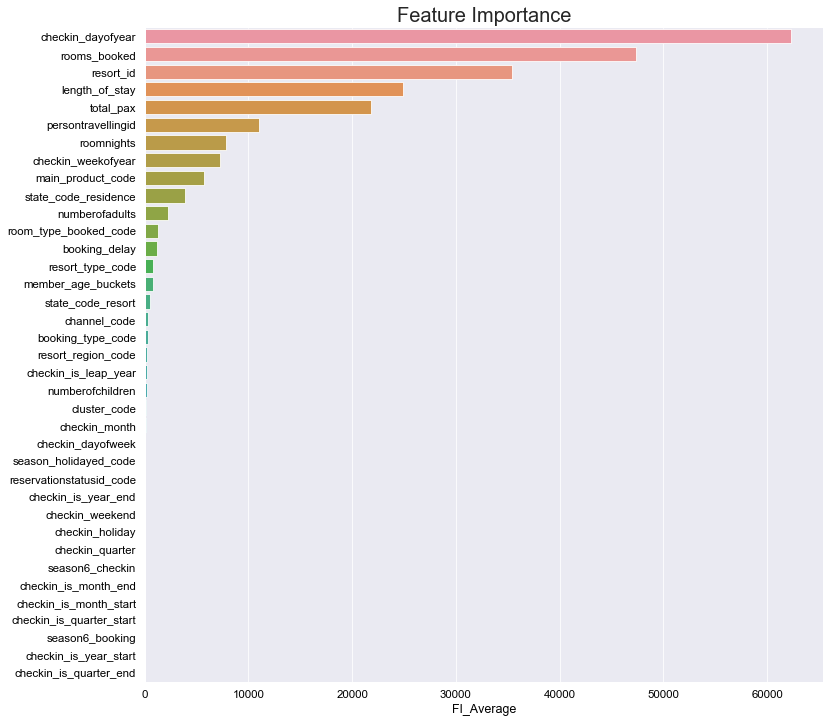

In [32]:
# Feature Importance
# Feature | FI_fold0 | FI_fold1 | FI_Average | FI_Std.dev(+/-) | Cumulative_Importance
plot = True
fold_importance_df = pd.DataFrame()
for fold, model, _ in cv_models:
    df = pd.DataFrame({"feature": X.columns, "importance": model.booster_.feature_importance(importance_type="gain")}) # model.booster_.feature_importance(importance_type="gain") ; model.feature_importances_
    df = df.set_index("feature")
    df.columns = ["FI_{}".format(fold)]
    fold_importance_df = pd.concat([fold_importance_df, df], axis=1)
    del df
    gc.collect()
fold_importance_df["FI_Average"] = fold_importance_df.apply(lambda x: np.mean(x), axis=1)
fold_importance_df["FI_Std_dev(+/-)"] = fold_importance_df.apply(lambda x: np.std(x), axis=1)
fold_importance_df["normalized"] = fold_importance_df["FI_Average"]/fold_importance_df["FI_Average"].sum()
fold_importance_df.sort_values(["normalized"], ascending=False, inplace=True)
fold_importance_df["Cumulative_Importance"] = fold_importance_df["normalized"].cumsum()
fold_importance_df.drop(columns=["normalized"], axis=1, inplace=True)

if plot:
    _ = sns.catplot(x="FI_Average", y="feature", data=fold_importance_df.reset_index().sort_values(["FI_Average"], ascending=False), kind="bar", 
                height = 10, aspect=1.2)
    plt.title("Feature Importance", fontdict={'fontsize': 20})
    plt.ylabel("")

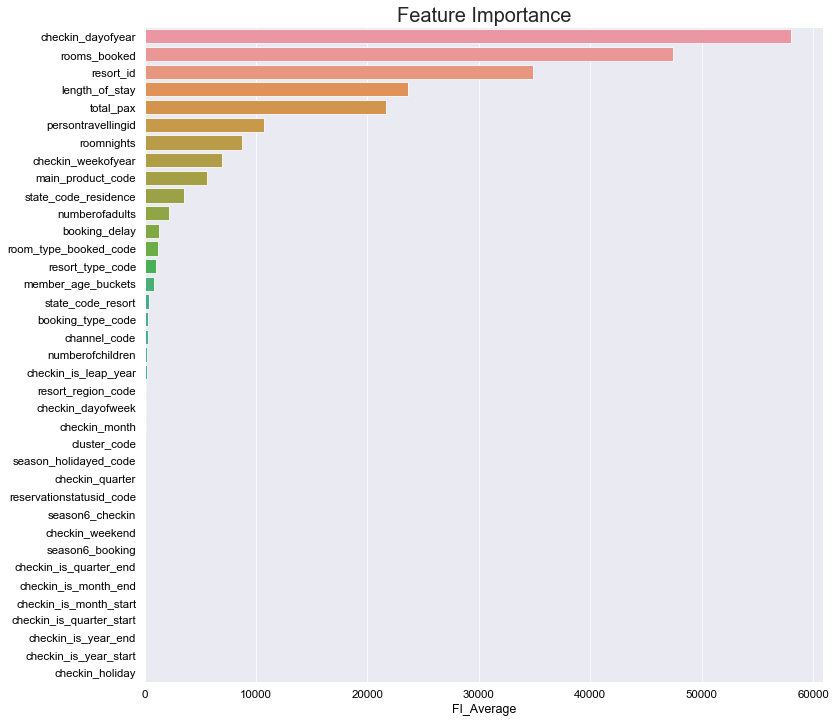

In [58]:
lgbreg.run_feat_importance(cv_models, X.drop([target], axis=1).columns, "gain")
lgbreg.plot_feat_importance("gain")

In [59]:
lgbreg.fold_split_importance_df

,FI_Iter1_fold0,FI_Iter1_fold1,FI_Average,FI_Std_dev(+/-),Cumulative_Importance
feature,,,,,
checkin_dayofyear,960,1000,980.000,16.330,0.432
resort_id,269,306,287.500,15.105,0.559
checkin_weekofyear,229,226,227.500,1.225,0.659
total_pax,109,113,111.000,1.633,0.708
state_code_residence,97,105,101.000,3.266,0.753
length_of_stay,89,89,89.000,0.000,0.792
main_product_code,72,82,77.000,4.082,0.826
persontravellingid,71,76,73.500,2.041,0.858
rooms_booked,68,69,68.500,0.408,0.888


In [34]:
# SHAP Values
# Feature | SHAP_Fold0 | SHAP_Fold0_Pos | SHAP_Fold0_Neg | SHAP_Fold1 | SHAP_Fold1_Pos | SHAP_Fold1_Neg | Avg_SHAP | Std_dev_SHAP | Sum_Pos | Sum_Neg | Std_Pos | Std_Neg
delete_fold_data = True
shap_df = pd.DataFrame()
for fold, model, val_idxs in cv_models:
    df = pd.DataFrame({"Features": X.columns})
    shap_values = model.predict(X.iloc[val_idxs, :], num_iteration=model.best_iteration_, pred_contrib=True) # last column is base value
    print(shap_values.shape)
    df["SHAP_{}".format(fold)] = np.mean(np.abs(shap_values[:, 0:len(X.columns)]), axis=0)*1000
    df["SHAP_{}_Pos".format(fold)] = [np.sum(shap_values[:, i] > 0) for i in range(0, len(X.columns))]
    df["SHAP_{}_Neg".format(fold)] = [np.sum(shap_values[:, i] < 0) for i in range(0, len(X.columns))]
    df["SHAP_{}_Zeros".format(fold)] = [np.sum(shap_values[:, i] == 0) for i in range(0, len(X.columns))]
    df = df.set_index("Features")
    shap_df = pd.concat([shap_df, df], axis=1)
    del shap_values
    gc.collect()

shap_names = ["SHAP_{}".format(fold) for fold, _, _ in cv_models]
shap_pos_names = ["SHAP_{}_Pos".format(fold) for fold, _, _ in cv_models]
shap_neg_names = ["SHAP_{}_Neg".format(fold) for fold, _, _ in cv_models]
shap_zeros_names = ["SHAP_{}_Zeros".format(fold) for fold, _, _ in cv_models]

shap_df["Avg_SHAP"] = shap_df[shap_names].apply(lambda x: np.mean(x), axis=1)
shap_df["Std_dev_SHAP"] = shap_df[shap_names].apply(lambda x: np.std(x), axis=1)
shap_df["Avg_POS_SHAP"] = shap_df[shap_pos_names].apply(lambda x: np.mean(x), axis=1)
shap_df["Std_POS_SHAP"] = shap_df[shap_pos_names].apply(lambda x: np.std(x), axis=1)
shap_df["Avg_NEG_SHAP"] = shap_df[shap_neg_names].apply(lambda x: np.mean(x), axis=1)
shap_df["Std_NEG_SHAP"] = shap_df[shap_neg_names].apply(lambda x: np.std(x), axis=1)
shap_df["Avg_ZEROS_SHAP"] = shap_df[shap_zeros_names].apply(lambda x: np.mean(x), axis=1)
shap_df["Std_ZEROS_SHAP"] = shap_df[shap_zeros_names].apply(lambda x: np.std(x), axis=1)

if delete_fold_data:
    shap_df.drop(shap_names+shap_pos_names+shap_neg_names+shap_zeros_names, axis=1, inplace=True)
shap_df.sort_values(["Avg_SHAP"], ascending=False, inplace=True)

del shap_names, shap_pos_names, shap_neg_names, shap_zeros_names
gc.collect()

(167338, 38)
(167337, 38)


70

In [35]:
shap_df

,Avg_SHAP,Std_dev_SHAP,Avg_POS_SHAP,Std_POS_SHAP,Avg_NEG_SHAP,Std_NEG_SHAP,Avg_ZEROS_SHAP,Std_ZEROS_SHAP
Features,,,,,,,,
rooms_booked,196.851,1.636,59150.000,2.000,108187.500,2.500,0.000,0.000
resort_id,148.193,0.415,95749.500,907.500,71588.000,908.000,0.000,0.000
length_of_stay,121.194,5.289,49592.000,884.000,117745.500,883.500,0.000,0.000
total_pax,115.327,0.552,108298.000,1768.000,59039.500,1767.500,0.000,0.000
persontravellingid,72.183,2.266,131534.000,30.000,35803.500,29.500,0.000,0.000
checkin_dayofyear,60.538,0.499,81864.000,272.000,85473.500,272.500,0.000,0.000
main_product_code,54.541,0.573,112816.500,589.500,54521.000,590.000,0.000,0.000
state_code_residence,34.129,0.890,77291.500,454.500,90046.000,455.000,0.000,0.000
numberofadults,16.366,0.515,65283.500,5110.500,102054.000,5110.000,0.000,0.000


In [60]:
lgbreg.run_shap_importance(cv_models, X, [target])

Shape of SHAP on validation set: (167338, 38)
Shape of SHAP on validation set: (167337, 38)


In [61]:
lgbreg.get_shap_frame()

,Avg_SHAP,Std_dev_SHAP,Avg_POS_SHAP,Std_POS_SHAP,Avg_NEG_SHAP,Std_NEG_SHAP,Avg_ZEROS_SHAP,Std_ZEROS_SHAP
Features,,,,,,,,
rooms_booked,196.557,1.268,59550.500,437.500,107787.000,437.000,0.000,0.000
resort_id,146.500,0.865,96335.000,1065.000,71002.500,1064.500,0.000,0.000
length_of_stay,116.993,7.888,54759.500,1608.500,112578.000,1608.000,0.000,0.000
total_pax,114.064,0.065,110876.500,843.500,56461.000,844.000,0.000,0.000
persontravellingid,70.762,0.819,131691.500,223.500,35646.000,223.000,0.000,0.000
checkin_dayofyear,59.110,1.219,81137.000,105.000,86200.500,104.500,0.000,0.000
main_product_code,53.213,2.847,112000.500,710.500,55337.000,711.000,0.000,0.000
state_code_residence,32.620,0.775,75341.000,1876.000,91996.500,1875.500,0.000,0.000
roomnights,17.764,2.525,54312.000,6347.000,113025.500,6347.500,0.000,0.000


In [36]:
# CV Predict
test_preds = 0
n_folds = 2
fold_weights = [1, 1]
for idx, cv_fold  in enumerate(cv_models):
    model = cv_fold[1]
    test_preds += model.predict(X_test)/n_folds * fold_weights[idx]
    
pred_df = pd.DataFrame({object_id: test_df[object_id], "target": test_preds})

In [37]:
pred_df.head()

,reservation_id,target
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d4787cb4596e3086b4f,7.852
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb1946e644b405d6233c,7.377
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e38f40dcb4ce0c4f552,7.599
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd26796a33cc98b01c6095c4,7.881
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1b2d117cd6602737ec1,7.766


In [77]:
X_test[object_id] = test_df[object_id]
lgbreg.cv_predict(cv_models, X_test, [object_id], object_id)[0:20]

,reservation_id,target
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d4787cb4596e3086b4f,7.920
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb1946e644b405d6233c,7.416
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e38f40dcb4ce0c4f552,7.454
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd26796a33cc98b01c6095c4,7.917
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1b2d117cd6602737ec1,7.842
5,69a8c691057e9396eaa23625a47435eebda41102b83dfb0d105c786f01495eb6,7.692
6,0cee97bb4f3b15493d20994fc4ef34b54d778f8eb7e6d3caf510409ee3fa644c,7.134
7,13fd266f2859828250494a72c5e14d12dfdb6cac0983d8faeec88bcbf5d1bf18,8.266
8,8a0e44a731edd24628fa9e9d5d2ed9b22f07e91b6881f24f42dd260962fd35a1,7.942
9,c3bdb69eedad1a992df7be568e50da86a4e1de8ad7ff3604a501a654c37f7aad,7.565


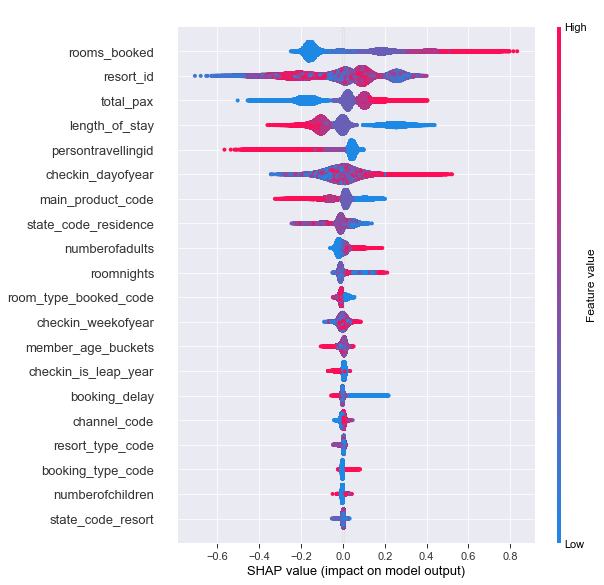

In [62]:
# shap summary plot
lgbreg.shap_summaryplot(X, cv_models[0][2], cv_models[0][1], [target])

In [65]:
lgbreg.shap_obs_explanation(X, cv_models[0][2][0:100], cv_models[0][1], [target])


SHAP base value: 7.728460908843459


In [66]:
# Dependence plots
shap_values = lgbreg.get_shap_values( X, cv_models[0][2][0:1000], cv_models[0][1], [target] )
shap_values.shape

(1000, 38)

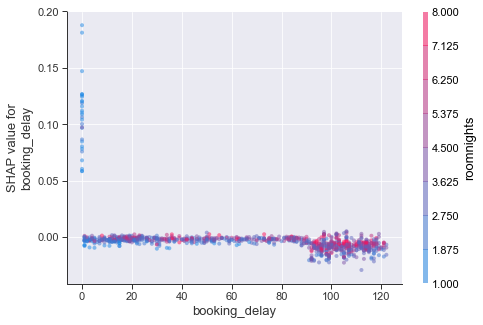

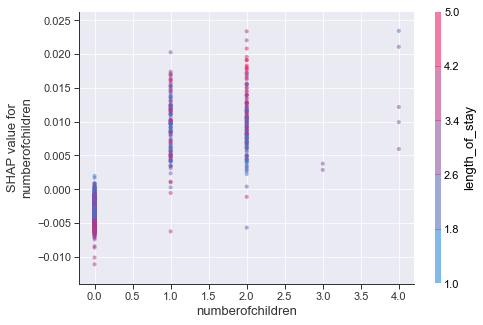

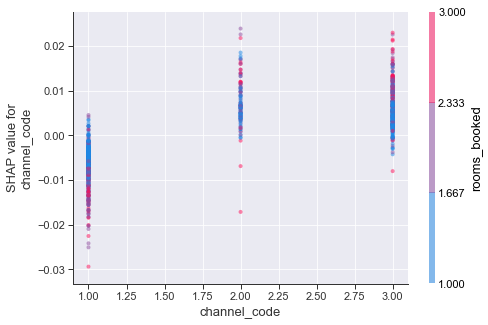

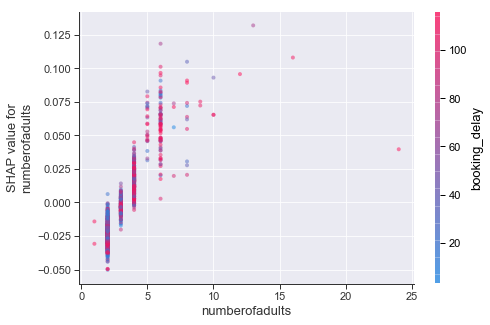

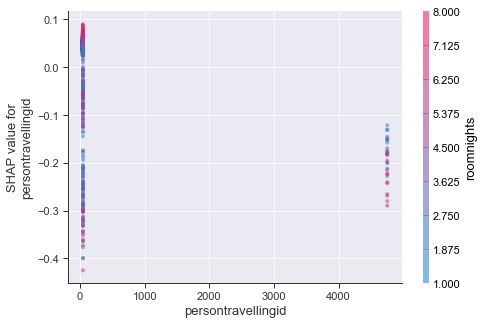

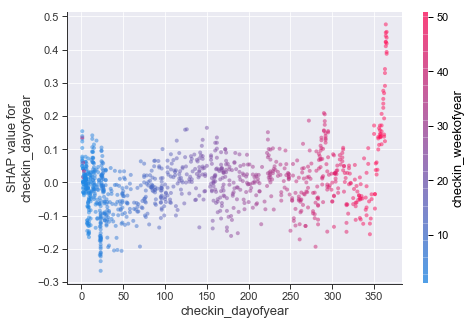

In [68]:
features = ["booking_delay", "numberofchildren", "channel_code", "numberofadults", "persontravellingid", "checkin_dayofyear"]
#features = ["season6_checkin"]
lgbreg.plot_shap_dependence(X, train_df, cv_models[0][2], [object_id, "memberid", target], shap_values, features, target, "auto", 1000)

Text(0.5, 1.0, 'LGBM Train-Valid rmse Score')

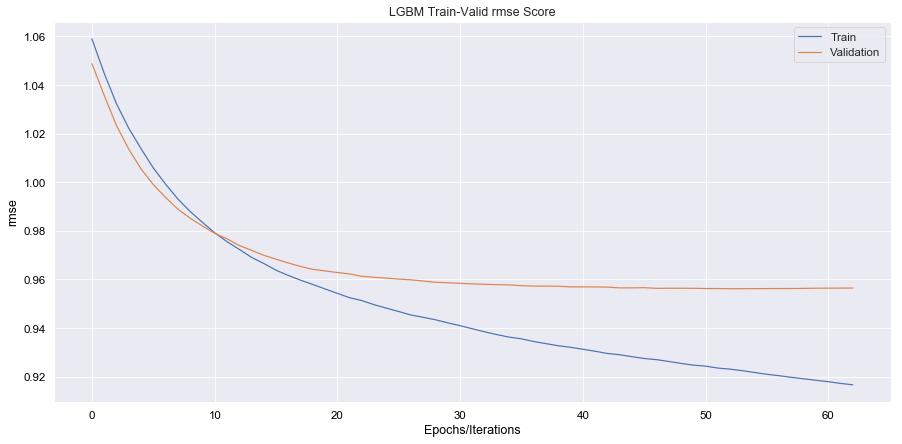

In [48]:
# Bias-Variance
#cv_models[0][1].evals_result_
results = cv_models[0][1].evals_result_
metric_name = "rmse"    
epochs = len(results['training'][metric_name])
x_axis = range(0, epochs)

# plot loss / auc
fig, ax = plt.subplots(1,1, figsize=(15, 7))
ax.plot(x_axis, results['training'][metric_name], label='Train')
ax.plot(x_axis, results['validation'][metric_name], label='Validation')
ax.legend()
ax.set_xlabel("Epochs/Iterations")
ax.set_ylabel(metric_name)
ax.set_title('LGBM Train-Valid {} Score'.format(metric_name))

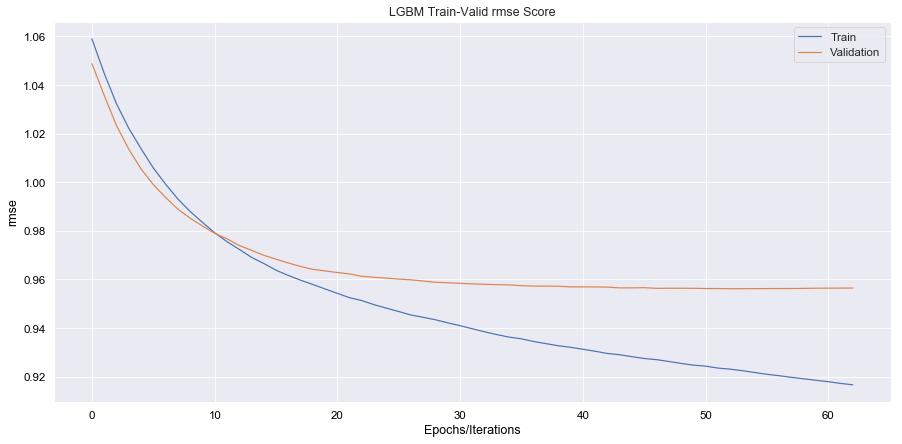

In [70]:
lgbreg.plot_loss(cv_models[0][1], "rmse")